In [1]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
# import imageio
# import moviepy.video.io.ImageSequenceClip
from tqdm import tqdm
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
from neuroprobe.config import NEUROPROBE_TASKS_MAPPING as task_name_mapping
import neuroprobe.config as neuroprobe_config
task_order = list(task_name_mapping.keys())

# Load single electrode results

In [22]:
import numpy as np
results_root = "data/single_electrode_eval_results_SS_DM/linear_stft_abs_nperseg512_poverlap0.75_maxfreq150_single_electrode/"
# results_root = "data/single_electrode_eval_results_SS_DM/linear_voltage_single_electrode/"

def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

  0%|                                                                                                                         | 0/300 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.30it/s]


# Plot brains

In [23]:
matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'analyses/time_space_decoding_analysis/'
base_path = os.path.join(neuroprobe_config.ROOT_DIR, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [99]:
spatial_avg_results_df = results_df.groupby(['task','ID']).mean(['avg_test'])
max_avg_test_perf = spatial_avg_results_df['avg_test'].values.max()


In [172]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.2, 'grey'), (0.4, 'yellow'), (1.0, 'red')])
grey_to_viridis = LinearSegmentedColormap.from_list('grey_to_viridis', [(0.0, 'grey'), (0.1, 'grey'), (1.0, '#fde725')])

lower = 0.500
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))
inverse_scale = lambda x: np.exp(x) + lower

In [178]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None, vmin=None, vmax=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df = plot_df.sort_values(by='avg_test', ascending=True)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']

    assert(list(sorted(color))==list(color))
    
    # Scale dot sizes based on color values - smaller for darker/grayer values
    min_size = 0
    max_size = 40
    scaled_color = np.maximum(color, 0.5).apply(scale)

    size_range = max_size - min_size
    sizes = min_size + size_range * np.minimum(1, (scaled_color - scale(0.50)) / (scale(0.7) - scale(0.50)))
    
    if vmin is None:
        vmin = scale(0.505)
    if vmax is None:
        vmax = scale(max_avg_test_perf)
    sc = ax.scatter(all_x, all_y,   
                s=sizes,
                linewidths=1,
                c=color.apply(scale),
                edgecolors="black",
                clip_on=False,
                # cmap="viridis",
                cmap=grey_to_red,
                vmin=vmin,
                vmax=vmax,
                   )
    return sc

/tmp/ipykernel_443045/708265667.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


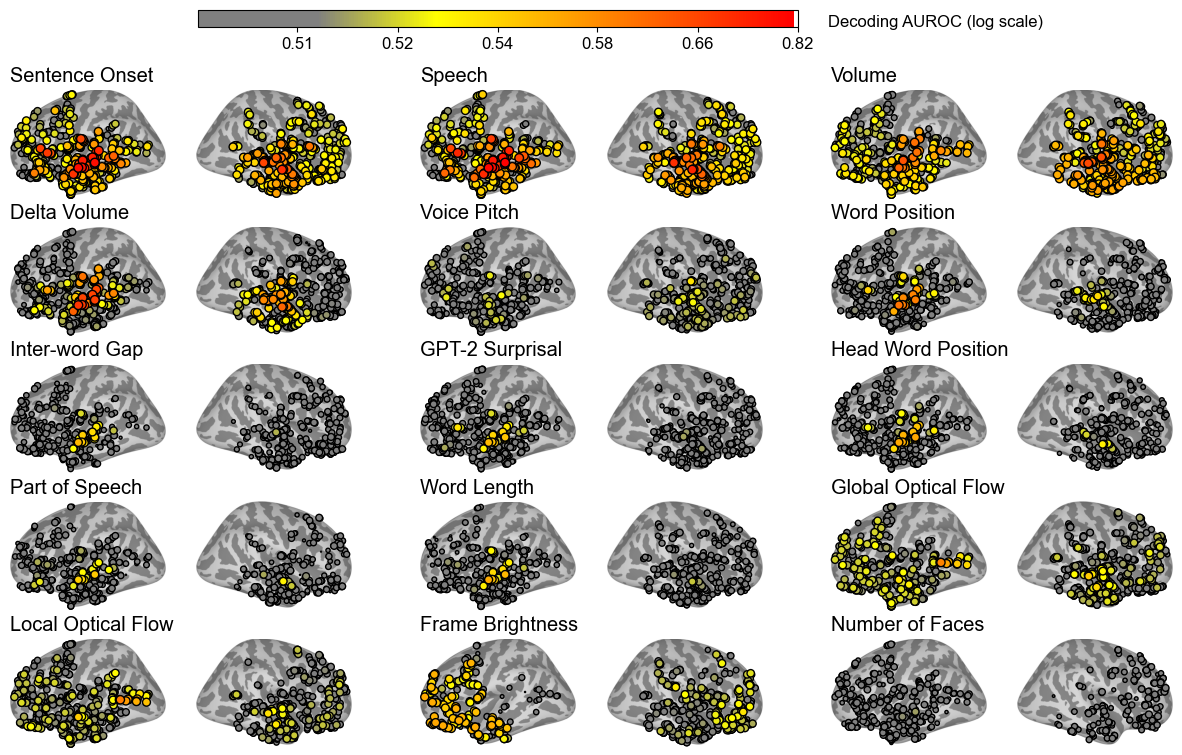

In [175]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.colorbar import ColorbarBase

fig = plt.figure(figsize=(15, 8.4))

# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

num_cols = 3
num_rows = 5

# Create main grid for plots
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2, top=0.9)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # Skip the last few cells since we only have tasks to fill
        if i*num_cols+j >= len(task_order):
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
            task = task_order[i*num_cols+j]
            task_df = spatial_avg_results_df.loc[task].copy()

            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task)
            
            if k == 0:
                ax.set_title(task_name_mapping[task], loc='left')
# Add colorbar at the top of the figure
cbar_ax = fig.add_axes([0.25, 0.97, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
# Set custom tick positions
custom_ticks = [0.51, 0.52, 0.54, 0.58, 0.66, 0.82]
cbar.set_ticks([scale(tick) for tick in custom_ticks])
cbar.ax.tick_params()
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
# Add label to the right of the colorbar
fig.text(0.67, 0.975, "Decoding AUROC (log scale)", ha='left', va='center')

plt.tight_layout()
plt.savefig('analyses/time_space_decoding_analysis/space_decoding_analysis.pdf', bbox_inches='tight')

/tmp/ipykernel_443045/1626562161.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(1.0, 1.0, 'GPT-2 Surprisal')

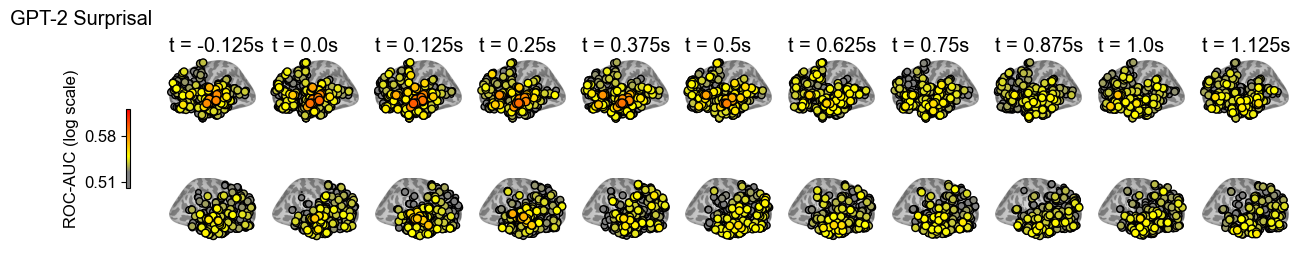

In [192]:
task = "gpt2_surprisal"

times = list(np.arange(-0.5, 1.25, 0.125))
fig = plt.figure(figsize=(15, 3))
selected_times = times[2::1]
num_cols = len(selected_times)
num_rows = 1

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.0, width_ratios = [0.3] + [1]*(num_cols-1))

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(1, num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[outer_idx], hspace=0.05
        )

        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            time = selected_times[j]
            task_df = results_df[results_df.time_bin==time].groupby(['task','ID']).max(['avg_test']).loc[task].copy()

            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task, vmax=scale(0.85))
            
            if k == 0:
                ax.set_title(f"t = {time}s", loc='left')

ax = fig.add_subplot(outer[0])
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', location='left')
cbar.ax.tick_params()
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
cbar.set_label("ROC-AUC (log scale)")
ax.set_axis_off()
plt.tight_layout()
plt.title(task_name_mapping[task], loc="right")